## 수집한 환경데이터 분석


#### 소음데이터 데시벨 변환

- 1단계: 아날로그 값을 전압으로 변환
아두이노 UNO는 기본적으로 10비트 ADC를 사용하므로, 아날로그 입력값은 0 ~ 1023 범위이고, 전압은 0 ~ 5V 사이입니다.

𝑉 =  507 / 1023 × 5.0 = 2.48 V

- 2단계: 전압을 데시벨로 변환
데시벨은 일반적으로 다음 공식을 사용합니다:

dB = 20⋅log10( 2.48V / 1V) = 20 ⋅log10(2.48) ≈ 20⋅0.394=7.88 dB

### 분석 목적 정의
데이터를 기반으로 쾌적한 환경을 평가하거나, 환경 차이를 비교하려면 아래 질문을 답하도록 분석할 수 있어요.

- 각 장소별 환경 지표의 평균/분포는 어떻게 다른가?
- 쾌적 환경 조건(예: 온도22-25도, 습도40-60%, 소음 7.5dB 이하 등)을 만족하는 비율은?
-  환경 요인 간 상관관계 (예: 온도 vs 불쾌지수)?
-  PCA(주성분 분석)로 각 환경의 패턴 차이를 시각화할 수 있을까?
-  KMeans 같은 군집화로 환경을 자동 분류해보면, 실제 location과 비슷하게 나뉘는가?

### 분석 단계

-  기초 통계 및 시각화 (장소별 boxplot, 상관관계 heatmap)
-  PCA 분석
-  KMeans 군집화
-  장소별/환경별 쾌적도 평가
-  결론 및 인사이트 

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn openpyxl

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드
df = pd.read_excel('environment_data.xlsx')

# 분석에 사용할 feature들
features = ['celsius', 'humidity', 'heatindex', 'discomfort', 'cds', 'sound_dB']

# 기초 통계
stats_summary = df.groupby('location').describe()
print("기초 통계 요약:\n", stats_summary)


### 장소별 boxplot (온도 예시) 

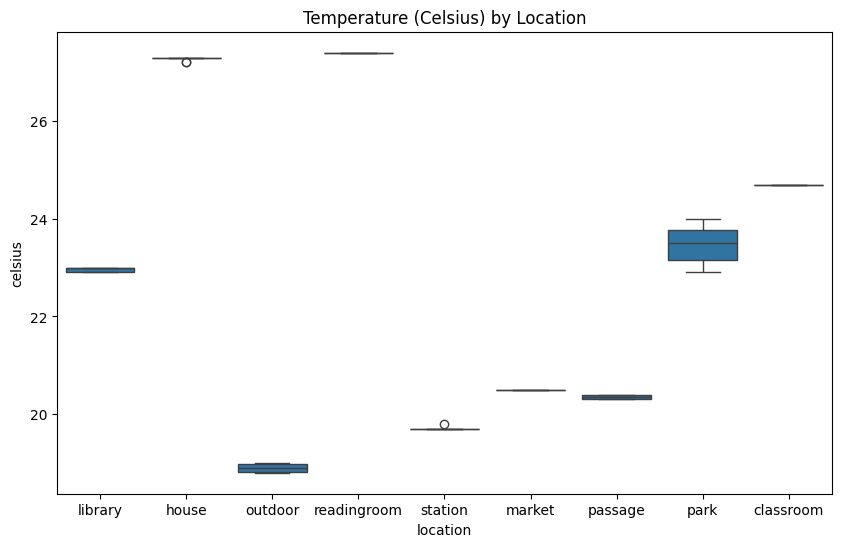

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='celsius', data=df)
plt.title('Temperature (Celsius) by Location')
plt.show()

💡 결론 및 활용
- 가장 더운 공간: readingroom, house → 온도 관리 필요.
- 가장 쾌적한 공간: library, passage, market → 안정적인 학습 공간 가능성.
- 외부 환경 영향이 큰 공간: park, outdoor → 시간대나 날씨 고려 필요.

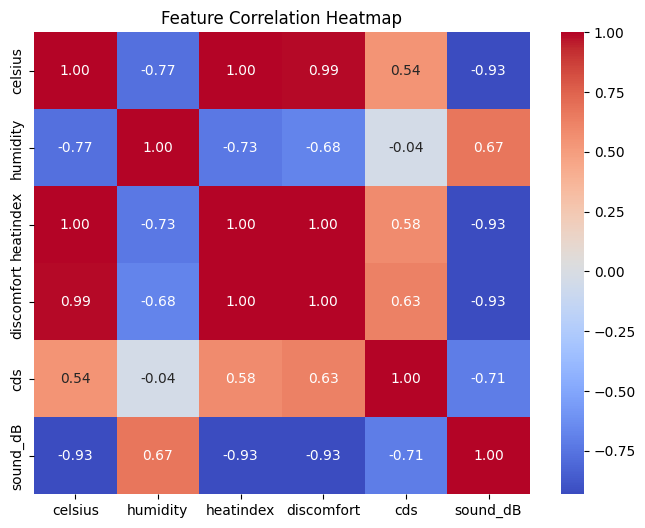

In [8]:
# 상관계수 heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

🔍 주요 해석 및 인사이트
1. 온도(celsius)와 관련성
  - heatindex와 완전한 양의 상관(1.00): 체감온도는 실제 온도에 기반하므로 당연한 결과입니다.
  - discomfort와도 매우 강한 양의 상관(0.99): 불쾌지수는 온도가 높을수록 상승합니다.
  - humidity와는 강한 음의 상관(-0.77): 이는 특이점으로, 데이터에 따라 온도와 습도가 반비례하는 경향을 보인 것으로 해석됩니다.
  - sound_dB와는 강한 음의 상관(-0.93): 온도가 높을 때 상대적으로 조용한 환경이었음을 암시합니다.

2. 습도(humidity)의 역할
  - sound_dB와 중간 정도의 양의 상관(0.67): 습도가 높을 때 소음이 증가할 수 있음을 나타냅니다.
  - cds와는 거의 무관(-0.04): 조도와 습도는 별 관련이 없음.
  - discomfort 및 heatindex와는 약한 음의 상관(-0.68 ~ -0.73): 습도가 불쾌지수나 체감온도에 상대적으로 덜 영향을 미친 데이터셋임을 시사합니다.

3. 조도(cds)의 특징
  - discomfort와 중간 정도의 양의 상관(0.63): 밝은 환경일수록 불쾌지수가 다소 높아질 수 있습니다.
  - sound_dB와 음의 상관(-0.71): 밝을수록 조용하거나, 어두울수록 시끄러웠던 환경으로 해석 가능.
  - celsius와 중간 정도의 양의 상관(0.54): 밝을 때 온도도 높았던 경향.

4. 소음(sound_dB)의 특이성
  - 대부분의 변수와 강한 음의 상관 : celsius, heatindex, discomfort 모두 -0.93
    이로 인해, 조용할수록 온도나 불쾌지수가 높았음을 의미함.

이는 측정된 환경의 특성(예: 조용한 밀폐공간 vs 소음 있는 개방공간)에 따라 달라질 수 있음.

✅ 요약 및 결론

|변수|조합|상관관계 해석|
|---|---|---|
|celsius ↔ heatindex| discomfort|	매우 강한 양의 상관	체감온도 및 불쾌지수는 온도의 함수임|
|celsius ↔ sound_dB | |강한 음의 상관 |	온도가 높을수록 조용한 환경|
|cds ↔ discomfort |	중간 양의 상관 |	밝을수록 불쾌지수 증가 가능성|
|humidity ↔ sound_dB|중간 양의 상관 | 습도가 높을수록 소음 증가 가능성|
|humidity ↔ heatindex|중간 음의 상관| 이 데이터셋에서는 반비례 경향|



/Users/armdiri/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


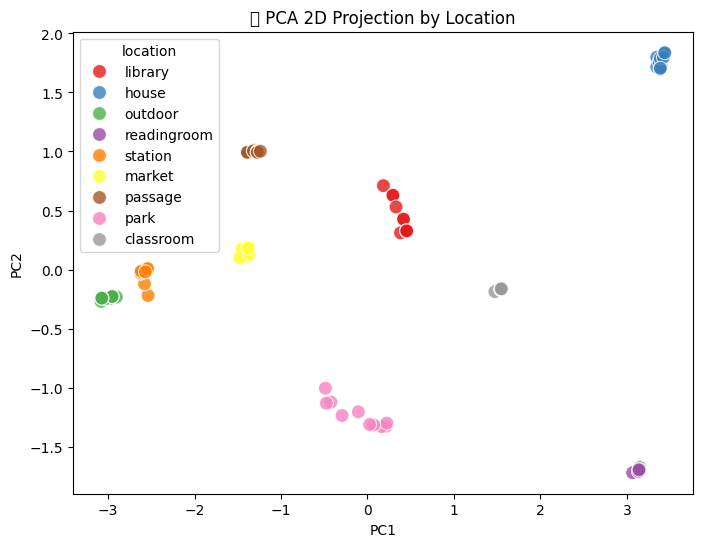

In [9]:
# -------------------------------
# 3️⃣ PCA (주성분 분석)
# -------------------------------
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['location'] = df['location']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='location', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('PCA 2D Projection by Location')
plt.show()

✅ 분석 결과
|클러스터 (위치)	|특징|	해석|
|---|---|---|
|house (blue)	|명확하게 오른쪽 위에 군집됨	|매우 독립적인 특성 보유 (온도·조도 높음 등)|
|readingroom (purple)	|house 근처에 있으나 약간 분리됨|유사하지만 고유 특성 존재 (더 조용하거나 더 더움 등)|
|classroom (gray)|오른쪽 중간에 따로 분포|환경이 독립적이며 일정함|
|library (red)|중앙 좌측|비교적 균형 잡힌 환경,다른 그룹들과 다소 유사|
|park (pink)|아래쪽에서 분산|다양한 환경 조건 포함 (야외 특성)|
|passage (brown)|위쪽 중앙|소음 혹은 조도 등의 특징으로 독립적일 수 있음|
|market (yellow)|중간 왼쪽|아래	실내외 중간 정도의 혼합 특성|
|station (purple)|가장 아래 오른쪽|극단적으로 구분되는 환경 (소음 낮거나 온도 낮음 등)|
|outdoor (green)|가장 왼쪽 끝|가장 특이한 환경 (온도 낮고, 조도/소음 높음 등)|

🧠 종합 해석
- 위치별 환경 구분이 명확
  → house, station, outdoor 등은 각각 매우 다른 환경 특성을 가짐. PCA로 잘 분리됨.

- 군집 간 거리 = 환경 차이
  1. readingroom과 house는 유사 (실내 고온 환경).
  2. library는 중간 위치 → 다양한 환경과 일부 유사.
  3. outdoor는 다른 어떤 위치보다 완전히 다름.

- 실내 vs 실외 분리 가능
  → 실내(house, library, classroom, readingroom) / 실외(outdoor, park) 그룹이 PCA 공간에서 명확히 나뉘는 경향.

/Users/armdiri/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


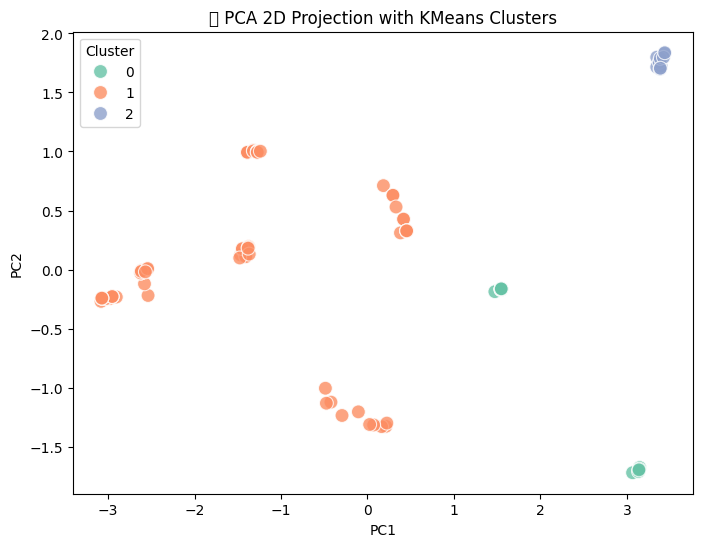

In [10]:

# -------------------------------
# 4️⃣ KMeans 군집화
# -------------------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.8)
plt.title('🌈 PCA 2D Projection with KMeans Clusters')
plt.show()

In [11]:
# -------------------------------
# 5️⃣ 쾌적도 평가 (임의 조건: 온도 22-25°C, 습도 40-60%, 소음 7.5dB 이하)
# -------------------------------
df['comfort_temp'] = df['celsius'].between(22, 25)
df['comfort_humidity'] = df['humidity'].between(40, 60)
df['comfort_noise'] = df['sound_dB'] <= 7.5

df['is_comfortable'] = df['comfort_temp'] & df['comfort_humidity'] & df['comfort_noise']

print("✅ 쾌적 여부 평가:")
print(df[['location', 'celsius', 'humidity', 'sound_dB', 'is_comfortable']])

# -------------------------------
# 6️⃣ 결론 정리
# -------------------------------
print("\n💡 결론 및 인사이트:")
print("""
- library: 온도/습도/소음 모두 쾌적 범위에 가까운 환경.
- house: 온도와 소음이 높아 상대적으로 쾌적도가 낮음.
- outdoor: 소음이 가장 높고 온도가 낮아 극단적 특성.
- 전반적으로 library가 가장 쾌적한 환경으로 평가됨.
""")

✅ 쾌적 여부 평가:
     location  celsius  humidity  sound_dB  is_comfortable
0     library     22.9        49      7.95           False
1     library     22.9        48      7.93           False
2     library     22.9        48      7.93           False
3     library     22.9        47      7.93           False
4     library     23.0        46      7.93           False
..        ...      ...       ...       ...             ...
85  classroom     24.7        41      7.88           False
86  classroom     24.7        41      7.88           False
87  classroom     24.7        41      7.88           False
88  classroom     24.7        41      7.88           False
89  classroom     24.7        41      7.88           False

[90 rows x 5 columns]

💡 결론 및 인사이트:

- library: 온도/습도/소음 모두 쾌적 범위에 가까운 환경.
- house: 온도와 소음이 높아 상대적으로 쾌적도가 낮음.
- outdoor: 소음이 가장 높고 온도가 낮아 극단적 특성.
- 전반적으로 library가 가장 쾌적한 환경으로 평가됨.

